# MNIST 数据集简介
它是一个手写数字数据集，包含了0 ~ 9这10个数字，一共有7万张灰度图像，其中6w张训练接，1w张测试集，并且每张都有标签，如标签0对应图像中数字0，标签1对应图像中数字1，以此类推...。 另外，在 MNIST 数据集中的每张图片由 28 x 28 个像素点构成, 每个像素点用一个灰度值表示,灰度值在0 ~ 1 或 0 ~ 255之间，MINIST数据集图像示例如下：

![MNIST.png](https://raw.githubusercontent.com/datawhalechina/dive-into-cv-pytorch/master/markdown_imgs/chapter01/1.5_FC_MNIST_Classification/MNIST.png)

# 全连接神经网络和激活函数
这里我就不多说了，大家还是看一下 Datawhale 的动手学 CV-PyTorch 的官方教程：
[1.5 初识图像分类：MNIST分类实战](https://datawhalechina.github.io/dive-into-cv-pytorch/#/chapter01_preliminary_knowledge/1.5_mnist_classification/README)

# 全连接神经网络（MLP）实现 MNIST 分类
## 首先导入相关模块

In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import mnist
from torchvision import transforms
import matplotlib.pyplot as plt

## 全连接网络构建
这里构建输入层、四层全连接层和输出层，输入层节点个数为 784，FC1 的节点个数为 512，FC2 的节点个数为 256，FC3 的节点个数为 128，输出节点的个数是 10（10 个分类）。每个全连接层都接有一个激活函数，我们使用 Relu。

In [4]:
# 定义网络结构
class Net(nn.Module):
    def __init__(self, in_c=784, out_c=10):
        super(Net, self).__init__()

        # 定义全连接层
        self.fc1 = nn.Linear(in_c, 512)
        # 定义激活层
        self.act1 = nn.ReLU(inplace=True)

        self.fc2 = nn.Linear(512, 256)
        self.act2 = nn.ReLU(inplace=True)

        self.fc3 = nn.Linear(256, 128)
        self.act3 = nn.ReLU(inplace=True)

        self.fc4 = nn.Linear(128, out_c)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))
        x = self.fc4(x)

        return x

# 构建网络
net = Net()

## 加载数据和网络输入
这里直接以 MNIST 数据集中图像的像素值作为特征输入，MNIST 图像的维度是 28 × 28 × 1 = 784，这里我们直接把 28 × 28 的像素值展开平铺为 784 × 1的数据输入给输入层，这个和我们定义的网络的输入维度是一致的：

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 58.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.77MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.8MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.65MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



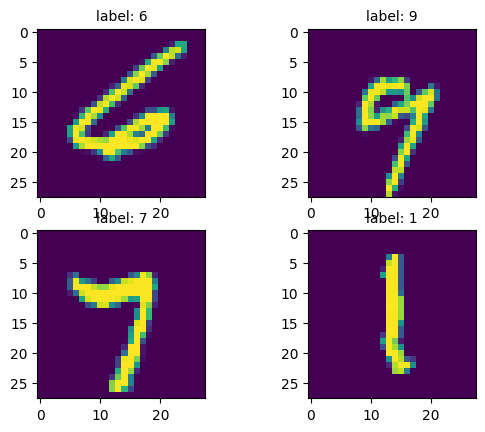

In [5]:
# 准备数据集
# 训练集
train_set = mnist.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)

# 测试集
test_set = mnist.MNIST('./data', train=False, transform=transforms.ToTensor(), download=True)

# 训练集载入器
train_data = DataLoader(train_set, batch_size=64, shuffle=True)

# 测试集载入器
test_data = DataLoader(test_set, batch_size=128, shuffle=False)

# 可视化数据
import random

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    idx = random.randint(0, len(train_set))
    digit_0 = train_set[idx][0].numpy()
    digit_0_image = digit_0.reshape(28, 28)
    ax.imshow(digit_0_image, interpolation="nearest")
    ax.set_title("label: {}".format(train_set[idx][1]), fontsize=10, color="black")

plt.show()

## 定义损失函数和优化器
这里为了更快的收敛并且效果较好，使用交叉熵作为损失函数。

有了模型，有了损失函数，现在还需要一个优化算法根据反向传播帮助我们进行权重修正，这里采用的优化方法为随机梯度下降（SGD），也可以使用 Adam 等。

In [6]:
# 定义损失函数——交叉熵
criterion = nn.CrossEntropyLoss()

# 定义优化器——随机梯度下降
optimizer = optim.SGD(net.parameters(), lr=1e-2, weight_decay=5e-4)

## 开始训练：前向传播和反向传播
准备工作都完成了，那么就开始训练！

这里先设置训练轮次为 20，可以自行修改查看结果的变化。

In [8]:
# 开始训练
# 记录训练损失
losses = []

# 记录训练精度
acces = []

# 记录测试损失
eval_losses = []

# 记录测试精度
eval_acces = []

# 设置迭代次数
nums_epoch = 20

for epoch in range(nums_epoch):
    train_loss = 0
    train_acc = 0
    net = net.train()

    for batch, (img, label) in enumerate(train_data):
        img = img.reshape(img.size(0), -1)
        img = Variable(img)
        label = Variable(label)

        # 前向传播
        out = net(img)
        loss = criterion(out, label)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]

        if (batch + 1) % 200 == 0:
            print("[INFO] Epoch-{}-Batch-{}: Train: Loss-{:.4f}. Accuracy-{:.4f}".format(epoch + 1, batch + 1, loss.item(), acc))

        train_acc += acc

    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))

    eval_loss = 0
    eval_acc = 0

    # 测试集不训练
    for img, label in test_data:
        img = img.reshape(img.size(0), -1)
        img = Variable(img)
        label = Variable(label)

        out = net(img)
        loss = criterion(out, label)

        # 记录误差
        eval_loss += loss.item()

        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]

        eval_acc += acc

    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))

    print("[INFO] Epoch-{}: Train: Loss-{:.4f}. Accuracy-{:.4f} | Test: Loss-{:.4f}, Accuracy-{:.4f}".format(epoch + 1, train_loss / len(train_data), train_acc / len(train_data), eval_loss / len(test_data), eval_acc / len(test_data)))


[INFO] Epoch-1-Batch-200: Train: Loss-1.2670. Accuracy-0.7031
[INFO] Epoch-1-Batch-400: Train: Loss-0.9629. Accuracy-0.8125
[INFO] Epoch-1-Batch-600: Train: Loss-0.6086. Accuracy-0.8125
[INFO] Epoch-1-Batch-800: Train: Loss-0.6496. Accuracy-0.8281
[INFO] Epoch-1: Train: Loss-0.9685. Accuracy-0.7581 | Test: Loss-0.5106, Accuracy-0.8494
[INFO] Epoch-2-Batch-200: Train: Loss-0.5420. Accuracy-0.8594
[INFO] Epoch-2-Batch-400: Train: Loss-0.3663. Accuracy-0.9531
[INFO] Epoch-2-Batch-600: Train: Loss-0.2919. Accuracy-0.8906
[INFO] Epoch-2-Batch-800: Train: Loss-0.5270. Accuracy-0.8125
[INFO] Epoch-2: Train: Loss-0.4473. Accuracy-0.8715 | Test: Loss-0.3776, Accuracy-0.8860
[INFO] Epoch-3-Batch-200: Train: Loss-0.4970. Accuracy-0.8438
[INFO] Epoch-3-Batch-400: Train: Loss-0.4281. Accuracy-0.8594
[INFO] Epoch-3-Batch-600: Train: Loss-0.6641. Accuracy-0.8125
[INFO] Epoch-3-Batch-800: Train: Loss-0.2713. Accuracy-0.9062
[INFO] Epoch-3: Train: Loss-0.3644. Accuracy-0.8953 | Test: Loss-0.3272, Accur

## 结果可视化
这里把训练完的结果可视化一下：

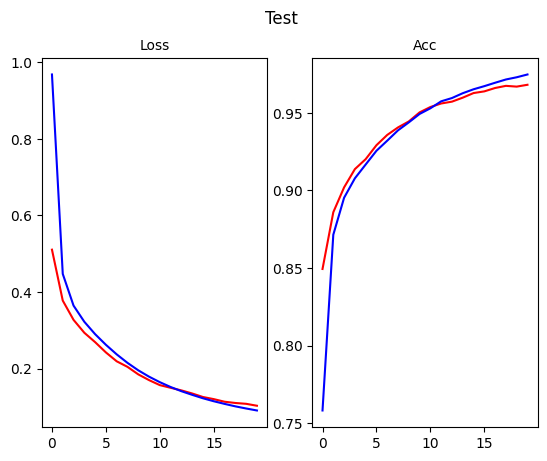

In [11]:
plt.figure()
plt.suptitle("Test", fontsize=12)
ax1 = plt.subplot(1, 2, 1)
ax1.plot(eval_losses, color="r")
ax1.plot(losses, color="b")
ax1.set_title("Loss", fontsize=10, color="black")
ax2 = plt.subplot(1, 2, 2)
ax2.plot(eval_acces, color="r")
ax2.plot(acces, color="b")
ax2.set_title("Acc", fontsize=10, color="black")
plt.show()

最后的结果大概在 0.97 多一些，这里不做额外的优化了，后面接触的多了再进行优化~